In [1]:
!pip install seaborn pyedflib pathlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [seaborn]


--- Data Generation Complete ---
Single series shape: (500,)
Ensemble shape: (1000, 500) (1000 realizations, 500 time points)
-----------------------------------

--- Analysis of a Single Realization ---
[White Noise] Mean: -0.0131
[White Noise] Variance: 0.9196

[Random Walk] Mean: -5.1902
[Random Walk] Variance: 20.6653



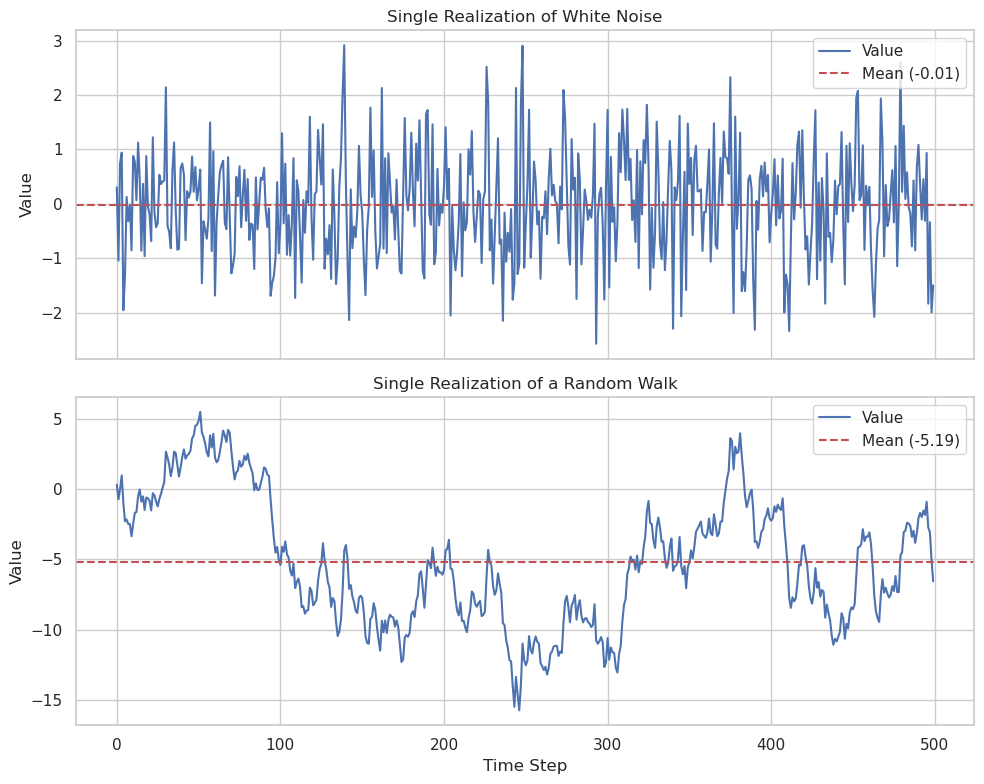

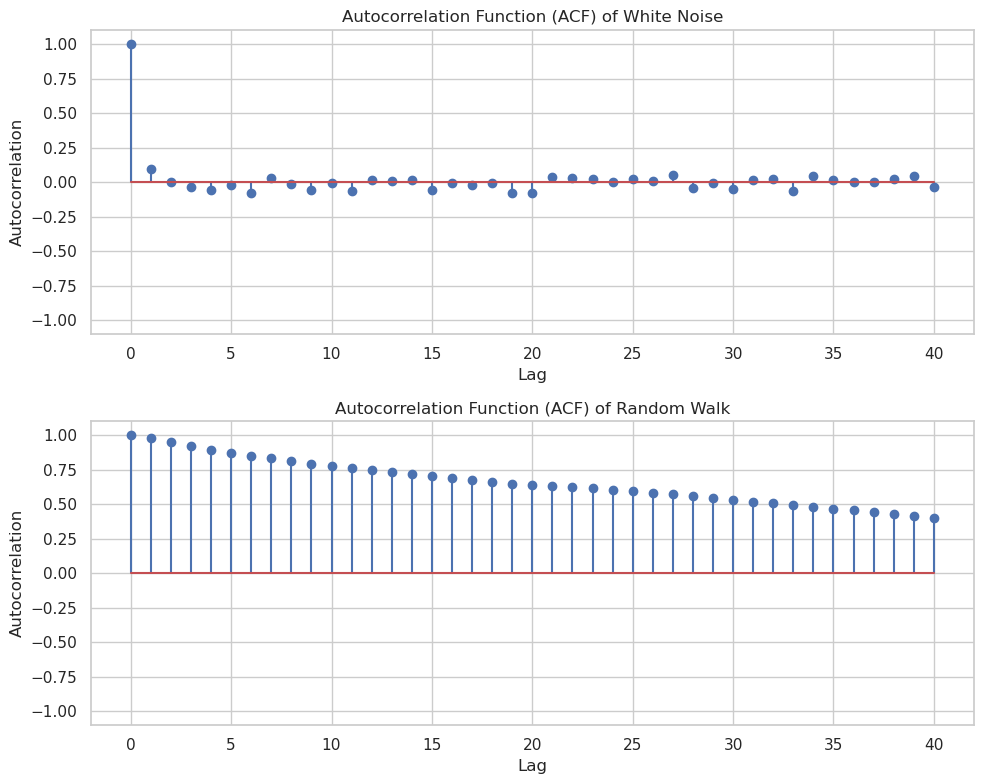


--- Augmented Dickey-Fuller Stationarity Test ---
[White Noise] ADF Statistic: -20.1265
[White Noise] p-value: 0.0000
Result: The p-value is very small, so we reject the null hypothesis. The white noise series is stationary.
--------------------
[Random Walk] ADF Statistic: -2.7059
[Random Walk] p-value: 0.0730
Result: The p-value is large, so we fail to reject the null hypothesis. The random walk series is non-stationary.
---------------------------------------------

--- Analysis of the Ensemble ---


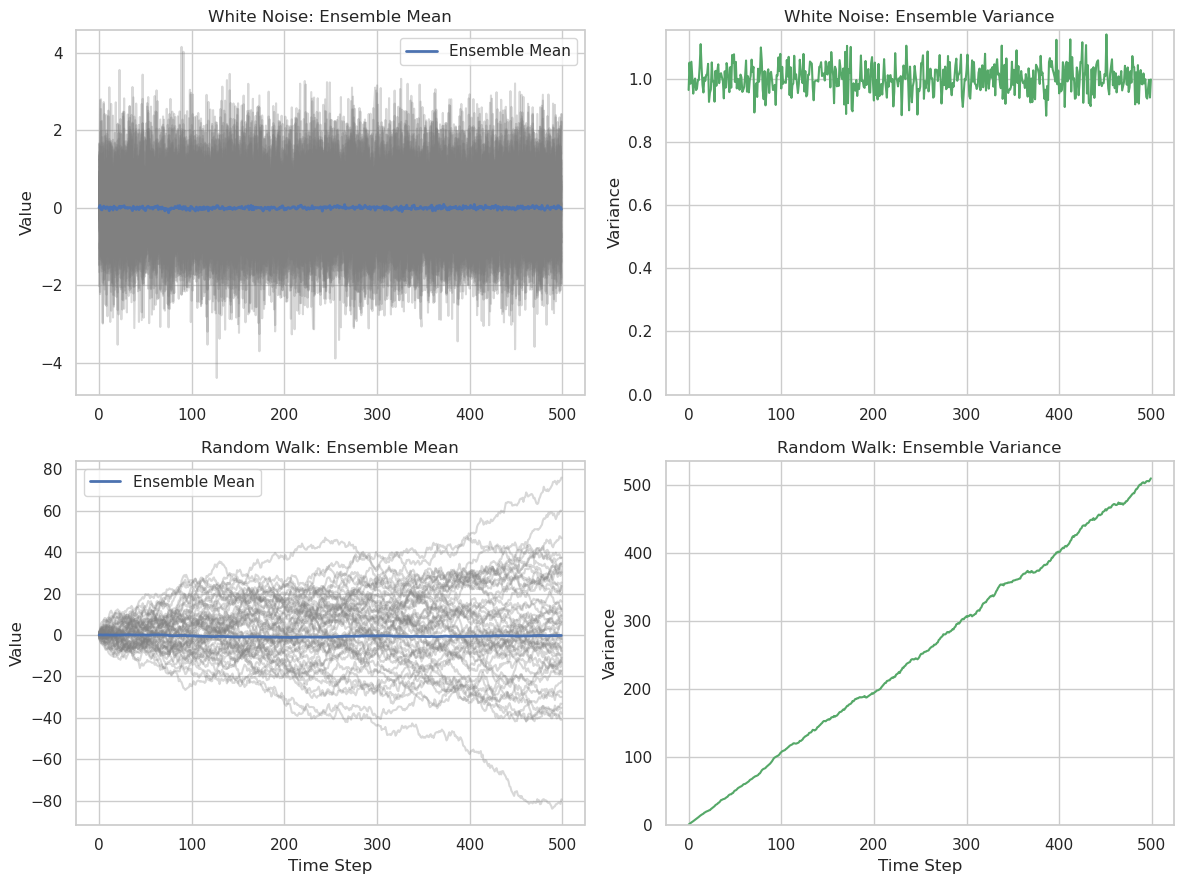


--- Analysis of Real-World EEG Data ---
Analyzing signal: 'EEG Fp1-REF' with 3603000 data points and sample rate 500.0 Hz.
[EEG Signal] Mean: 0.3947
[EEG Signal] Variance: 71638.1204



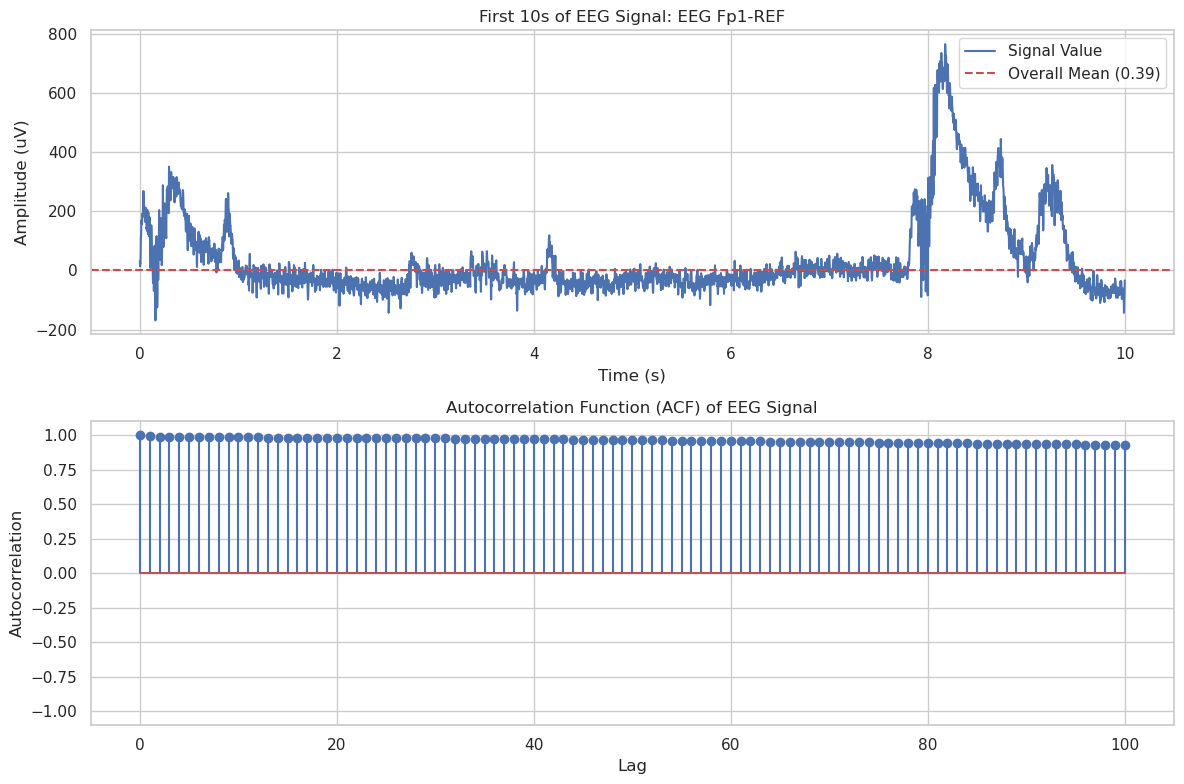


--- Augmented Dickey-Fuller Stationarity Test (EEG) ---
[EEG Signal] ADF Statistic: -10.0222
[EEG Signal] p-value: 0.0000
Result: The p-value is small. We reject the null hypothesis, suggesting the EEG series is stationary.
--------------------------------------------------


--- Artefact Analysis and Filtering ---


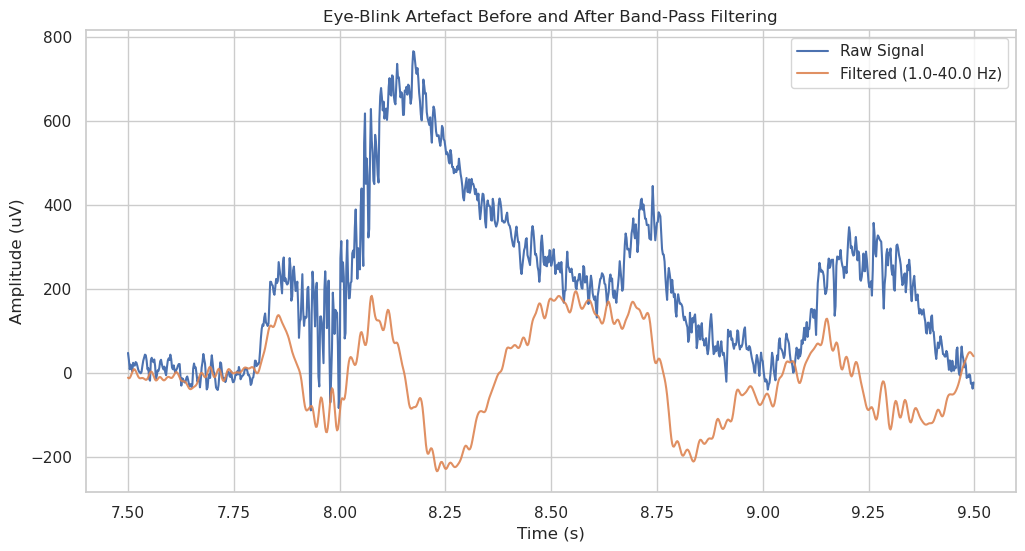


--- Spectrogram Analysis ---


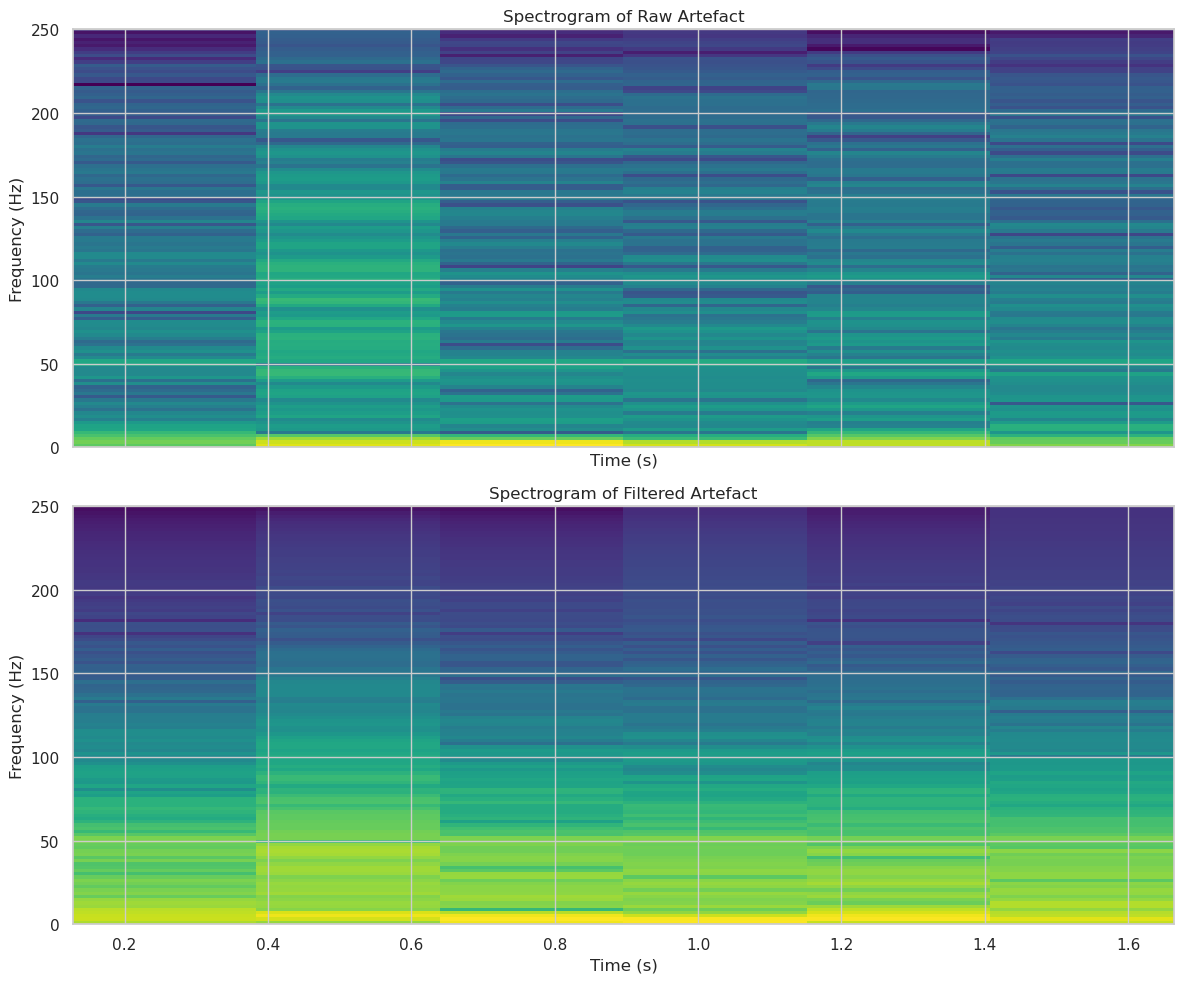

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf
from pandas.plotting import autocorrelation_plot
import pyedflib.highlevel as highlevel
import os
from scipy.signal import butter, lfilter

# --- Plotting Configuration ---
# Adjust plot size & resolution.
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
sns.set_theme(style="whitegrid")

# --- Experiment Parameters ---
N_POINTS = 500  # Number of time steps in each series
N_ENSEMBLE = 1000 # Number of realizations for the ensemble analysis
RNG = np.random.default_rng(seed=42) # Random number generator for reproducibility

# ==============================================================================
# PART 1: GENERATE TIME SERIES DATA
# ==============================================================================

# Generate a single realization of white noise
# White noise is a series of independent and identically distributed random variables
# with a mean of 0 and constant variance.
white_noise_single = RNG.standard_normal(N_POINTS)

# A random walk is the cumulative sum of a white noise series.
# The value at time 't' is the value at 't-1' plus a white noise term.
random_walk_single = np.cumsum(white_noise_single)

# Generate an ensemble of realizations for both types
white_noise_ensemble = RNG.standard_normal(size=(N_ENSEMBLE, N_POINTS))
random_walk_ensemble = np.cumsum(white_noise_ensemble, axis=1)

print("--- Data Generation Complete ---")
print(f"Single series shape: {white_noise_single.shape}")
print(f"Ensemble shape: {white_noise_ensemble.shape} ({N_ENSEMBLE} realizations, {N_POINTS} time points)")
print("-" * 35 + "\n")


# ==============================================================================
# PART 2: ANALYSIS OF A SINGLE REALIZATION
# ==============================================================================

print("--- Analysis of a Single Realization ---")

# --- White Noise Analysis ---
wn_mean = np.mean(white_noise_single)
wn_var = np.var(white_noise_single)
print(f"[White Noise] Mean: {wn_mean:.4f}")
print(f"[White Noise] Variance: {wn_var:.4f}")

# --- Random Walk Analysis ---
rw_mean = np.mean(random_walk_single)
rw_var = np.var(random_walk_single)
print(f"\n[Random Walk] Mean: {rw_mean:.4f}")
print(f"[Random Walk] Variance: {rw_var:.4f}\n")

# --- Plotting Single Realizations ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax1.plot(white_noise_single, label='Value')
ax1.axhline(wn_mean, color='r', linestyle='--', label=f'Mean ({wn_mean:.2f})')
ax1.set_title('Single Realization of White Noise')
ax1.set_ylabel('Value')
ax1.legend()

ax2.plot(random_walk_single, label='Value')
ax2.axhline(rw_mean, color='r', linestyle='--', label=f'Mean ({rw_mean:.2f})')
ax2.set_title('Single Realization of a Random Walk')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Value')
ax2.legend()

plt.tight_layout()
plt.show()


# --- Autocorrelation Analysis ---
# We calculate the Autocorrelation Function (ACF)
# nlags specifies how many time lags to include.
wn_acf = acf(white_noise_single, nlags=40)
rw_acf = acf(random_walk_single, nlags=40)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plotting ACF for White Noise
# The 'use_line_collection' argument is removed as it's deprecated in newer matplotlib versions.
ax1.stem(wn_acf)
ax1.set_title('Autocorrelation Function (ACF) of White Noise')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelation')
ax1.set_ylim([-1.1, 1.1])

# Plotting ACF for Random Walk
# The 'use_line_collection' argument is removed as it's deprecated in newer matplotlib versions.
ax2.stem(rw_acf)
ax2.set_title('Autocorrelation Function (ACF) of Random Walk')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Autocorrelation')
ax2.set_ylim([-1.1, 1.1])

plt.tight_layout()
plt.show()


# --- Stationarity Test (Augmented Dickey-Fuller) ---
# The null hypothesis (H0) of the ADF test is that the time series is non-stationary
# (i.e., it has a unit root).
# If the p-value is below a threshold (e.g., 0.05), we reject H0 and conclude
# that the series is stationary.

print("\n--- Augmented Dickey-Fuller Stationarity Test ---")
adf_wn_result = adfuller(white_noise_single)
print(f"[White Noise] ADF Statistic: {adf_wn_result[0]:.4f}")
print(f"[White Noise] p-value: {adf_wn_result[1]:.4f}")
print(f"Result: The p-value is very small, so we reject the null hypothesis. The white noise series is stationary.")

print("-" * 20)

adf_rw_result = adfuller(random_walk_single)
print(f"[Random Walk] ADF Statistic: {adf_rw_result[0]:.4f}")
print(f"[Random Walk] p-value: {adf_rw_result[1]:.4f}")
print(f"Result: The p-value is large, so we fail to reject the null hypothesis. The random walk series is non-stationary.")
print("-" * 45 + "\n")


# ==============================================================================
# PART 3: ANALYSIS OF THE ENSEMBLE
# ==============================================================================

print("--- Analysis of the Ensemble ---")

# Calculate the mean and variance across the ensemble for each time point (axis=0)
ensemble_mean_wn = np.mean(white_noise_ensemble, axis=0)
ensemble_var_wn = np.var(white_noise_ensemble, axis=0)

ensemble_mean_rw = np.mean(random_walk_ensemble, axis=0)
ensemble_var_rw = np.var(random_walk_ensemble, axis=0)

# --- Plotting Ensemble Statistics ---
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# Plot a few sample realizations to visualize the ensemble
for i in range(50):
    axes[0, 0].plot(white_noise_ensemble[i, :], color='grey', alpha=0.3)
axes[0, 0].plot(ensemble_mean_wn, color='b', linewidth=2, label='Ensemble Mean')
axes[0, 0].set_title('White Noise: Ensemble Mean')
axes[0, 0].set_ylabel('Value')
axes[0, 0].legend()

axes[0, 1].plot(ensemble_var_wn, color='g')
axes[0, 1].set_title('White Noise: Ensemble Variance')
axes[0, 1].set_ylabel('Variance')
axes[0, 1].set_ylim(bottom=0) # Variance can't be negative

# Plot a few sample realizations of the random walk
for i in range(50):
    axes[1, 0].plot(random_walk_ensemble[i, :], color='grey', alpha=0.3)
axes[1, 0].plot(ensemble_mean_rw, color='b', linewidth=2, label='Ensemble Mean')
axes[1, 0].set_title('Random Walk: Ensemble Mean')
axes[1, 0].set_xlabel('Time Step')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()

axes[1, 1].plot(ensemble_var_rw, color='g')
axes[1, 1].set_title('Random Walk: Ensemble Variance')
axes[1, 1].set_xlabel('Time Step')
axes[1, 1].set_ylabel('Variance')
axes[1, 1].set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# ==============================================================================
# PART 4: ANALYSIS OF REAL-WORLD EEG DATA
# ==============================================================================
print("\n--- Analysis of Real-World EEG Data ---")

# NOTE: You must have the '01.edf' file in a 'data/seizure_eeg_data' subdirectory
# relative to where you run this script.
fn = 'data/seizure_eeg_data/01.edf'

if not os.path.exists(fn):
    print(f"ERROR: Data file not found at '{fn}'")
    print("Please create a 'data/seizure_eeg_data' folder and place '01.edf' inside it.")
else:
    # Read the EDF file
    raw_signals, signal_headers, header = highlevel.read_edf(str(fn))
    
    # Select the first EEG channel for analysis
    eeg_signal = raw_signals[0]
    eeg_label = signal_headers[0]['label']
    sample_rate = signal_headers[0]['sample_frequency']
    
    print(f"Analyzing signal: '{eeg_label}' with {len(eeg_signal)} data points and sample rate {sample_rate} Hz.")

    # --- Statistical Analysis ---
    eeg_mean = np.mean(eeg_signal)
    eeg_var = np.var(eeg_signal)
    print(f"[EEG Signal] Mean: {eeg_mean:.4f}")
    print(f"[EEG Signal] Variance: {eeg_var:.4f}\n")

    # --- Plotting the EEG Signal ---
    # To make the plot readable, we'll only show the first few seconds
    time_to_plot_s = 10
    points_to_plot = int(time_to_plot_s * sample_rate)
    time_axis = np.arange(points_to_plot) / sample_rate
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    ax1.plot(time_axis, eeg_signal[:points_to_plot], label='Signal Value')
    ax1.axhline(eeg_mean, color='r', linestyle='--', label=f'Overall Mean ({eeg_mean:.2f})')
    ax1.set_title(f'First {time_to_plot_s}s of EEG Signal: {eeg_label}')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude (uV)')
    ax1.legend()

    # --- Autocorrelation Analysis ---
    eeg_acf = acf(eeg_signal, nlags=100) # Use more lags for higher sample rate data
    ax2.stem(eeg_acf)
    ax2.set_title('Autocorrelation Function (ACF) of EEG Signal')
    ax2.set_xlabel('Lag')
    ax2.set_ylabel('Autocorrelation')
    ax2.set_ylim([-1.1, 1.1])
    
    plt.tight_layout()
    plt.show()

    # --- Stationarity Test (Augmented Dickey-Fuller) ---
    print("\n--- Augmented Dickey-Fuller Stationarity Test (EEG) ---")
    # We test on a subset of the data to avoid memory issues with very long signals
    adf_eeg_result = adfuller(eeg_signal[:50000]) 
    print(f"[EEG Signal] ADF Statistic: {adf_eeg_result[0]:.4f}")
    print(f"[EEG Signal] p-value: {adf_eeg_result[1]:.4f}")
    if adf_eeg_result[1] < 0.05:
        print(f"Result: The p-value is small. We reject the null hypothesis, suggesting the EEG series is stationary.")
    else:
        print(f"Result: The p-value is large. We fail to reject the null hypothesis, suggesting the EEG series is non-stationary.")
    print("-" * 50 + "\n")

# ==============================================================================
# PART 5: ARTEFACT ANALYSIS AND FILTERING
# ==============================================================================
    print("\n--- Artefact Analysis and Filtering ---")

    # --- Isolate the Artefact ---
    # From visual inspection, a large artefact occurs around 8-9 seconds.
    start_time_s = 7.5
    end_time_s = 9.5
    start_idx = int(start_time_s * sample_rate)
    end_idx = int(end_time_s * sample_rate)
    
    artefact_segment = eeg_signal[start_idx:end_idx]
    artefact_time_axis = np.arange(len(artefact_segment)) / sample_rate + start_time_s

    # --- Design and Apply a Band-Pass Filter ---
    def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        y = lfilter(b, a, data)
        return y

    # Define frequency band of interest (e.g., 1-40 Hz)
    lowcut = 1.0
    highcut = 40.0
    
    eeg_signal_filtered = butter_bandpass_filter(eeg_signal, lowcut, highcut, sample_rate)
    artefact_segment_filtered = eeg_signal_filtered[start_idx:end_idx]

    # --- Plot Artefact Before and After Filtering ---
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(artefact_time_axis, artefact_segment, label='Raw Signal')
    ax.plot(artefact_time_axis, artefact_segment_filtered, label=f'Filtered ({lowcut}-{highcut} Hz)', alpha=0.9)
    ax.set_title('Eye-Blink Artefact Before and After Band-Pass Filtering')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude (uV)')
    ax.legend()
    plt.show()

    # --- Optional: Spectrogram Analysis ---
    print("\n--- Spectrogram Analysis ---")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, sharey=True)

    # Spectrogram of the raw artefact
    ax1.specgram(artefact_segment, Fs=sample_rate, NFFT=256, noverlap=128, cmap='viridis')
    ax1.set_title('Spectrogram of Raw Artefact')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Frequency (Hz)')
    ax1.set_ylim([0, highcut + 10]) # Limit y-axis to see detail

    # Spectrogram of the filtered artefact
    ax2.specgram(artefact_segment_filtered, Fs=sample_rate, NFFT=256, noverlap=128, cmap='viridis')
    ax2.set_title('Spectrogram of Filtered Artefact')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Frequency (Hz)')

    plt.tight_layout()
    plt.show()


In [4]:
start_time_s = 7.5
end_time_s = 9.5
start_idx = int(start_time_s * sample_rate)
end_idx = int(end_time_s * sample_rate)

artefact_segment = eeg_signal[start_idx:end_idx]

eeg_signal_filtered = butter_bandpass_filter(eeg_signal, lowcut, highcut, sample_rate)
artefact_segment_filtered = eeg_signal_filtered[start_idx:end_idx]


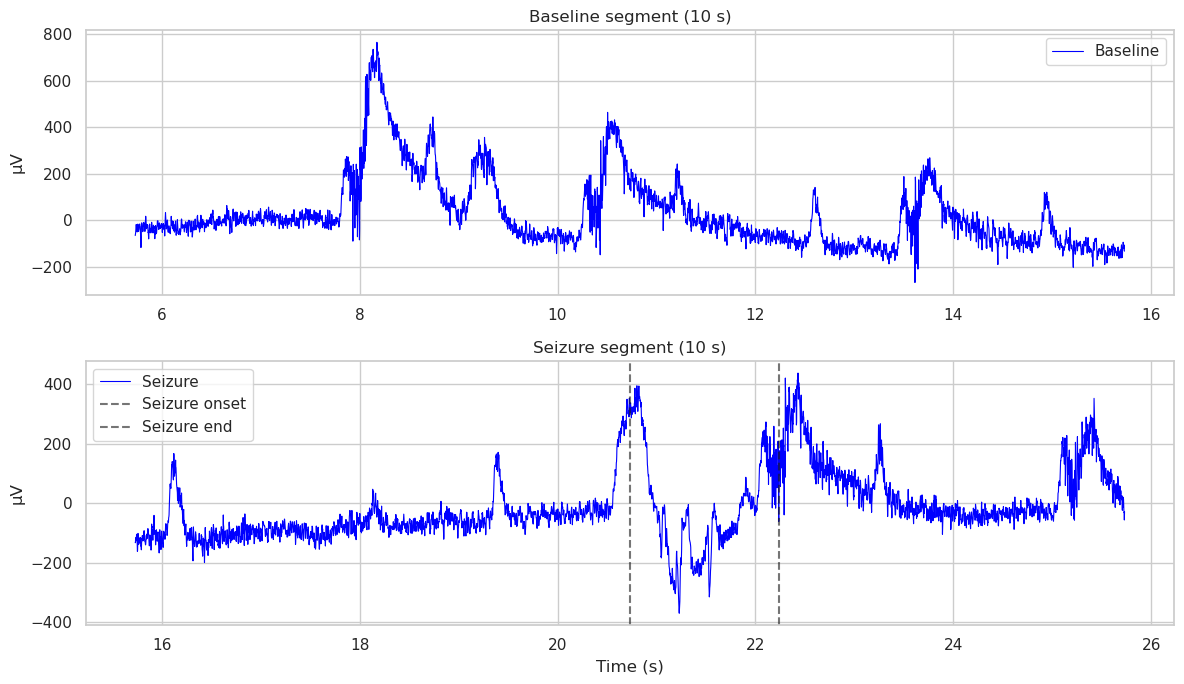

Baseline (10 s): mean=28.45 µV, var=23792.50, peak-to-peak=1032.71 µV
Seizure  (10 s): mean=-12.34 µV, var=13616.10, peak-to-peak=808.41 µV


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pyedflib
import pyedflib.highlevel as highlevel

# ---- Load EDF + annotations ----
edf_path = 'data/seizure_eeg_data/01.edf'

signals, sig_hdrs, hdr = highlevel.read_edf(edf_path)
fs = sig_hdrs[0]['sample_frequency']
eeg = signals[0]   # first channel, adjust if needed
n_samples = len(eeg)
duration = 10.0  # seconds for both windows
win_n = int(duration * fs)

# Use low-level reader to access annotations
with pyedflib.EdfReader(edf_path) as f:
    ann_onsets, ann_durations, ann_labels = f.readAnnotations()

# Gather seizure annotations
seizures = [(on, dur, lab) for on, dur, lab in zip(ann_onsets, ann_durations, ann_labels)
            if 'seizure' in lab.lower()]
if not seizures:
    raise ValueError("No 'Seizure' annotations found in this EDF.")

# ---- Pick one seizure and build fixed 10 s windows ----
sz_on, sz_dur, _ = seizures[0]

# Seizure window: [onset-5s, onset+5s], with bounds checking
sz_start_sec = max(0.0, sz_on - duration/2)
sz_end_sec   = sz_start_sec + duration
if sz_end_sec > n_samples / fs:  # shift left if we hit the end
    sz_end_sec = n_samples / fs
    sz_start_sec = sz_end_sec - duration

sz_i0, sz_i1 = int(sz_start_sec * fs), int(sz_end_sec * fs)
t_seiz = np.arange(sz_i0, sz_i1) / fs
seizure = eeg[sz_i0:sz_i1]

# Baseline window: 10 s ending 5 s before onset (or as early as possible)
base_end_sec = max(0.0, sz_on - 5.0)
base_start_sec = max(0.0, base_end_sec - duration)
# If the signal is too short at the beginning, extend to 10 s if possible
if (base_end_sec - base_start_sec) < duration and (sz_on > duration + 1.0):
    base_end_sec = sz_on - 1.0
    base_start_sec = base_end_sec - duration

b_i0, b_i1 = int(base_start_sec * fs), int(base_end_sec * fs)
t_base = np.arange(b_i0, b_i1) / fs
baseline = eeg[b_i0:b_i1]

# ---- Plots ----
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=False)

axes[0].plot(t_base, baseline, color='blue', linewidth=0.8, label='Baseline')
axes[0].set_title('Baseline segment (10 s)')
axes[0].set_ylabel('µV')
axes[0].legend()

axes[1].plot(t_seiz, seizure, color='blue', linewidth=0.8, label='Seizure')
# draw onset/end markers only if they fall in the displayed window
if sz_on >= t_seiz[0] and sz_on <= t_seiz[-1]:
    axes[1].axvline(sz_on, color='k', ls='--', alpha=0.6, label='Seizure onset')
if (sz_on + sz_dur) >= t_seiz[0] and (sz_on + sz_dur) <= t_seiz[-1]:
    axes[1].axvline(sz_on + sz_dur, color='k', ls='--', alpha=0.6, label='Seizure end')
axes[1].set_title('Seizure segment (10 s)')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('µV')
axes[1].legend()

plt.tight_layout()
plt.show()

# ---- Quick stats for your write-up ----
def stats(x): return np.mean(x), np.var(x), np.ptp(x)
b_mean, b_var, b_ptp = stats(baseline)
s_mean, s_var, s_ptp = stats(seizure)
print(f"Baseline (10 s): mean={b_mean:.2f} µV, var={b_var:.2f}, peak-to-peak={b_ptp:.2f} µV")
print(f"Seizure  (10 s): mean={s_mean:.2f} µV, var={s_var:.2f}, peak-to-peak={s_ptp:.2f} µV")
